# Get ASOH Data for All CAMP Cells
We'll use the CAMP data for now

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from moirae.interface.hdf5 import HDF5Writer
from moirae.interface import run_online_estimate, run_model
from moirae.estimators.offline.loss import MeanSquaredLoss
from moirae.estimators.offline.scipy import ScipyMinimizer
from moirae.estimators.online.joint import JointEstimator
from moirae.extractors.ecm import MaxCapacityExtractor, OCVExtractor
from moirae.models.ecm import EquivalentCircuitModel, ECMTransientVector, ECMInput
from moirae.models.base import GeneralContainer, HealthVariable
from battdat.data import CellDataset
from roviweb.utils import load_variable
from pathlib import Path
from tqdm import tqdm
import numpy as np
import warnings

In [2]:
camp_dir = Path('../../publishing-camp-data/data/hdf5/refined')
estimator_path = Path('../tests/files/diagnosis/example-estimator.py')
write_dir = Path('asoh-estimates')

In [3]:
write_dir.mkdir(exist_ok=True, parents=True)

## Develop Offline State Estimation
Build a function which guesses ASOH based on the first few cycles

In [4]:
ex_path = next(camp_dir.rglob('*h5'))
ex_data = CellDataset.from_hdf(ex_path)
ex_data.tables['raw_data'] = ex_data.raw_data.query('cycle_number < 4')
print(f'Loaded data from {ex_path}')

Loaded data from ..\..\publishing-camp-data\data\hdf5\refined\batch_B10A_cell_3.h5


C:\Users\lward\AppData\Local\miniconda3\envs\roviweb\Lib\site-packages\battdat\data.py:56: UserWarning: Metadata was created in a different version of battdat. supplied=0.4.0, current=0.4.2.
  warnings.warn(f'Metadata was created in a different version of battdat. supplied={supplied_version}, current={__version__}.')


In [5]:
asoh = load_variable(estimator_path.read_text(), 'initial_asoh', working_dir=estimator_path.parent)
state = load_variable(estimator_path.read_text(), 'initial_transients', working_dir=estimator_path.parent)
perform_offline_estimation = load_variable(estimator_path.read_text(), 'perform_offline_estimation', working_dir=estimator_path.parent)
before_asoh = asoh.model_copy(deep=True)

Run the forward 

In [6]:
state

ECMTransientVector(soc=array([[0.]]), q0=None, i_rc=array([], shape=(1, 0), dtype=float64), hyst=array([[0.]]))

In [7]:
before_v = run_model(
    model=EquivalentCircuitModel(),
    asoh=before_asoh,
    state_0=state,
    dataset=ex_data
)

Text(0, 0.5, 'Voltage (V)')

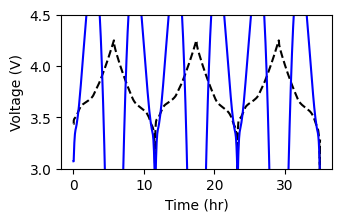

In [8]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

tt = ex_data.raw_data['test_time'] / 3600.
ax.plot(tt - tt.min(), ex_data.raw_data['voltage'], 'k--')
ax.plot(tt - tt.min(), before_v, 'b-')

ax.set_ylim([3, 4.5])

ax.set_xlabel('Time (hr)')
ax.set_ylabel('Voltage (V)')

Run the ASOH fit under different settings

In [9]:
%%time
qtonly_asoh, _ = perform_offline_estimation(ex_data, before_asoh, state, extract_q_t=True, extract_ocv=False, offline_fits=())
qtocv_asoh, _ = perform_offline_estimation(ex_data, before_asoh, state, extract_q_t=True, extract_ocv=True, offline_fits=())
all_asoh, all_start = perform_offline_estimation(ex_data, before_asoh, state, extract_q_t=True, extract_ocv=True, offline_fits=('r0.base_values',))

CPU times: total: 1min 25s
Wall time: 1min 34s


Plot the changes in the parameters

Text(0.5, 0, 'SOC')

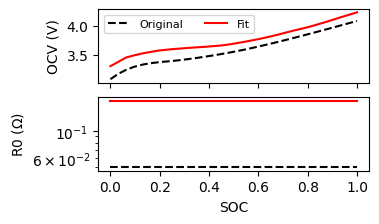

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(3.5, 2.1), sharex=True)

soc = np.linspace(0, 1, 32)[:, None]

ax = axs[0]
ax.plot(soc, before_asoh.ocv(soc)[0, :], 'k--', label='Original')
ax.plot(soc, all_asoh.ocv(soc)[0, :], 'r-', label='Fit')
ax.set_ylabel('OCV (V)')
ax.legend(ncol=2, fontsize=8)

ax = axs[1]
ax.plot(soc, before_asoh.r0.get_value(soc)[0, :], 'k--', label='Original')
ax.semilogy(soc, all_asoh.r0.get_value(soc)[0, :], 'r-', label='Fit')

ax.set_ylabel('R0 ($\\Omega$)')
ax.set_xlabel('SOC')


Plot changes in model performance

In [11]:
%%time
qtonly_v = run_model(model=EquivalentCircuitModel(), asoh=qtonly_asoh, state_0=state, dataset=ex_data)['terminal_voltage']
qtocv_v = run_model(model=EquivalentCircuitModel(), asoh=qtocv_asoh, state_0=state, dataset=ex_data)['terminal_voltage']
all_v = run_model(model=EquivalentCircuitModel(), asoh=all_asoh, state_0=all_start, dataset=ex_data)['terminal_voltage']

CPU times: total: 828 ms
Wall time: 932 ms


Text(0, 0.5, 'Voltage (V)')

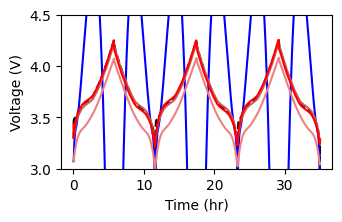

In [12]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

tt = ex_data.raw_data['test_time'] / 3600.
ax.plot(tt - tt.min(), ex_data.raw_data['voltage'], 'k--')
ax.plot(tt - tt.min(), before_v, 'b-', label='Original')
ax.plot(tt - tt.min(), qtonly_v, '-', color='lightcoral', label='$Q_T$')
ax.plot(tt - tt.min(), qtocv_v, '-', color='indianred', label='$Q_T$, OCV')
ax.plot(tt - tt.min(), all_v, 'r-', label='$Q_T$, OCV, R0')
#ax.legend(ncols=2, fontsize=8)

ax.set_ylim([3, 4.5])

ax.set_xlabel('Time (hr)')
ax.set_ylabel('Voltage (V)')

# Run State Estimation on All
Load a fresh estimator, run estimation storing every cycle, continue

In [13]:
make_estimator =  load_variable(estimator_path.read_text(), 'make_estimator', working_dir=estimator_path.parent)

In [ ]:
temp_path = Path('temp.asoh.h5')
files = list(camp_dir.rglob('*h5'))
for file in tqdm(files):
    # Skip if already done
    out_path = write_dir / file.with_suffix('.asoh.h5').name
    if out_path.exists():
        continue

    # Estimate the capacity, OCV, and r0 based on the first few cycles
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        data = CellDataset.from_hdf(file)
    data.tables['raw_data'] = data.raw_data.query('cycle_number < 5')
    initial_asoh, initial_state = perform_offline_estimation(data, before_asoh, state, extract_q_t=True, extract_ocv=True, offline_fits=('r0.base_values',))
    
    # Load the estimator and update the initial q_t
    estimator = make_estimator(initial_asoh, initial_state)
     
    # Run and write estimates to temp file
    temp_path.unlink(missing_ok=True)
    writer = HDF5Writer(hdf5_output=temp_path, 
                        per_timestep='mean_var',
                        per_cycle='full',
                        table_options={'complib': 'zlib', 'complevel': 9})
    try:
        run_online_estimate(file, estimator, output_states=False, hdf5_output=writer)
    except np.linalg.LinAlgError:
        continue

    # Copy temp to true
    temp_path.rename(out_path)

  0%|                                                                                                                                                                                                                                                          | 0/300 [00:00<?, ?it/s]